In [1]:
import os 
import wget
import datetime
import dateutil
import gzip
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy
import sklearn
import tensorflow as tf
import time
from collections import defaultdict
from pyfm import pylibfm
from sklearn.feature_extraction import DictVectorizer
from sklearn import linear_model

Data is available at http://cseweb.ucsd.edu/~jmcauley/pml/data/. 
- Download and save to your own directory.
- Or, run following script to save it into `Chapter_7/data` folder automatically.

In [2]:
filenames = [
    '201408_trip_data.csv',
    '201402_trip_data.csv',
    'goodreads_reviews_fantasy_paranormal.json.gz',
    'goodreads_reviews_comics_graphic.json.gz',
]

dataDir = './data'
url = 'http://jmcauley.ucsd.edu/pml_data'

if not os.path.exists(dataDir):
    os.makedirs(dataDir)
for filename in filenames:
    wget.download(os.path.join(url, filename), out=dataDir)

print("Done!")

Done!


# Autoregression

Example based on Bay-Area bike-share data. Extract the time information from the events.

In [3]:
events = {}

for f in [os.path.join(dataDir, "201408_trip_data.csv"), os.path.join(dataDir, "201402_trip_data.csv")]:
    f = open(f, 'r')
    l = f.readline()
    for l in f:
        l = l.split(',')
        tripID = l[0]
        timeString = l[2]
        timeUnix =\
            time.mktime(datetime.datetime.strptime(timeString, "%m/%d/%Y %H:%M").timetuple())
        events[tripID] = [timeUnix, timeString]

Find the earliest event (so that we can sort events from the first to the last hour)

In [4]:
earliest = None
for event in events:
    if earliest == None or events[event][0] < earliest[0]:
        earliest = events[event]

In [5]:
earliestTime = earliest[0]

Count events by hour

In [6]:
hourly = defaultdict(int)

for event in events:
    t = events[event][0]
    hour = int(t - earliestTime) // (60*60)
    hourly[hour] += 1

Autoregressive feature representation. Here we don't include a bias term, though could easily include one.

In [7]:
def feature(hour):
    previousHours = []
    # Features for last 5 hours, one day ago, one week ago, and one year ago
    for i in [1,2,3,4,5,24,24*7,24*7*365]:
        previousHour = hour - i
        previousHourExists = previousHour in hourly
        if previousHourExists:
            previousHours += [hourly[previousHour]]
        else:
            previousHours += [0]
    return previousHours

In [8]:
X = np.array([feature(x) for x in hourly])
y = np.array([hourly[x] for x in hourly])

In [9]:
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)
theta = model.coef_

The observation one week ago is the most predictive, followed by the observation from the previous hour:

In [10]:
theta

array([ 0.47105067, -0.28432565,  0.10555845,  0.01445134, -0.02131945,
        0.17501989,  0.53969635,  0.        ])

# Sliding window

Parse ratings and timestamps from (a small fraction of) Goodreads fantasy novel data

In [11]:
ratingsTime = []
z = gzip.open(os.path.join(dataDir, "goodreads_reviews_fantasy_paranormal.json.gz"))

for l in z:
    d = eval(l)
    t = dateutil.parser.parse(d['date_updated'])
    ratingsTime.append((t,d['rating']))
    if len(ratingsTime) >= 50000:
        break

Sort observations by time

In [12]:
ratingsTime.sort()
len(ratingsTime)

50000

Keep track of a window (wSize) of ratings and timestamps (the raw time is just for printing the plot)

In [13]:
wSize = 1000
x = [r[0] for r in ratingsTime] # as raw times
y = [r[1] for r in ratingsTime] # ratings
xu = [time.mktime(d.timetuple()) for d in x] # as unix times

Use a dynamic-programming approach to build the sliding window

In [14]:
xSum = sum(xu[:wSize])
ySum = sum(y[:wSize])
sliding = []

In [15]:
for i in range(wSize,len(x)-1):
    xSum += xu[i] - xu[i-wSize]
    ySum += y[i] - y[i-wSize]
    sliding.append((xSum*1.0/wSize,ySum*1.0/wSize))

X and Y coordinates for plotting

In [16]:
X = [a[0] for a in sliding]
Y = [a[1] for a in sliding]

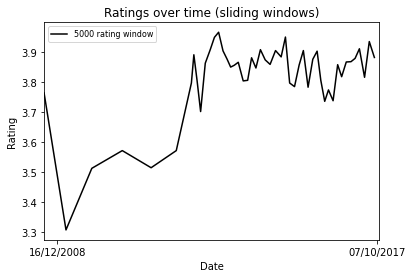

In [17]:
plt.plot(X[::1000],Y[::1000], label="5000 rating window", color='k')
plt.xticks([X[600], X[-350]], [x[wSize+600].strftime("%d/%m/%Y"), x[-350].strftime("%d/%m/%Y")])
plt.xlim(X[0], X[-1])
plt.ylabel("Rating")
plt.xlabel("Date")
plt.legend(loc="best",fontsize=8)
plt.title("Ratings over time (sliding windows)")
plt.show()

# FPMC in Tensorflow

In [18]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

Extract the interaction data, including the timestamps associated with each interaction

In [19]:
userIDs = {}
itemIDs = {}
interactions = []
interactionsPerUser = defaultdict(list)

for d in parse(os.path.join(dataDir, "goodreads_reviews_comics_graphic.json.gz")):
    u = d['user_id']
    i = d['book_id']
    t = d['date_added']
    r = d['rating']
    dt = dateutil.parser.parse(t)
    t = int(dt.timestamp())
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)
    interactions.append((t,u,i,r))
    interactionsPerUser[u].append((t,i,r))

Interaction with timestamp

In [20]:
interactions[0]

(1386269065, 'dc3763cdb9b2cae805882878eebb6a32', '18471619', 3)

In [21]:
len(interactions)

542338

Sort interactions by time (including interaction sequences for each user). Useful when building data structures that include adjacent pairs of interactions (but consider whether this is desirable if making train/test splits!).

In [22]:
interactions.sort()

In [23]:
itemIDs['dummy'] = len(itemIDs)

Build a data structure including users, items, and their previous items

In [24]:
interactionsWithPrevious = []

for u in interactionsPerUser:
    interactionsPerUser[u].sort()
    lastItem = 'dummy'
    for (t,i,r) in interactionsPerUser[u]:
        interactionsWithPrevious.append((t,u,i,lastItem,r))
        lastItem = i

In [25]:
itemsPerUser = defaultdict(set)
for _,u,i,_ in interactions:
    itemsPerUser[u].add(i)

In [26]:
items = list(itemIDs.keys())

Define the tensorflow model. Similar to models from Chapter 5, with the addition of the term associated with the previous interaction.

In [27]:
optimizer = tf.keras.optimizers.Adam(0.1)

FMPC class. UI and IJ are given as initialization options, allowing us to exclude certain terms (for exercises later).

In [28]:
class FPMC(tf.keras.Model):
    def __init__(self, K, lamb, UI = 1, IJ = 1):
        super(FPMC, self).__init__()
        # Initialize variables
        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001))
        self.gammaUI = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001))
        self.gammaIU = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        self.gammaIJ = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        self.gammaJI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        # Regularization coefficient
        self.lamb = lamb
        # Which terms to include
        self.UI = UI
        self.IJ = IJ

    # Prediction for a single instance
    def predict(self, u, i, j):
        p = self.betaI[i] + self.UI * tf.tensordot(self.gammaUI[u], self.gammaIU[i], 1) +\
                            self.IJ * tf.tensordot(self.gammaIJ[i], self.gammaJI[j], 1)
        return p

    # Regularizer
    def reg(self):
        return self.lamb * (tf.nn.l2_loss(self.betaI) +\
                            tf.nn.l2_loss(self.gammaUI) +\
                            tf.nn.l2_loss(self.gammaIU) +\
                            tf.nn.l2_loss(self.gammaIJ) +\
                            tf.nn.l2_loss(self.gammaJI))

    def call(self, sampleU, # user
                   sampleI, # item
                   sampleJ, # previous item
                   sampleK): # negative item
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        j = tf.convert_to_tensor(sampleJ, dtype=tf.int32)
        k = tf.convert_to_tensor(sampleK, dtype=tf.int32)
        gamma_ui = tf.nn.embedding_lookup(self.gammaUI, u)
        gamma_iu = tf.nn.embedding_lookup(self.gammaIU, i)
        gamma_ij = tf.nn.embedding_lookup(self.gammaIJ, i)
        gamma_ji = tf.nn.embedding_lookup(self.gammaJI, j)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        x_uij = beta_i + self.UI * tf.reduce_sum(tf.multiply(gamma_ui, gamma_iu), 1) +\
                         self.IJ * tf.reduce_sum(tf.multiply(gamma_ij, gamma_ji), 1)
        gamma_uk = tf.nn.embedding_lookup(self.gammaUI, u)
        gamma_ku = tf.nn.embedding_lookup(self.gammaIU, k)
        gamma_kj = tf.nn.embedding_lookup(self.gammaIJ, k)
        gamma_jk = tf.nn.embedding_lookup(self.gammaJI, j)
        beta_k = tf.nn.embedding_lookup(self.betaI, k)
        x_ukj = beta_k + self.UI * tf.reduce_sum(tf.multiply(gamma_uk, gamma_ku), 1) +\
                         self.IJ * tf.reduce_sum(tf.multiply(gamma_kj, gamma_jk), 1)
        return -tf.reduce_mean(tf.math.log(tf.math.sigmoid(x_uij - x_ukj)))

In [29]:
modelFPMC = FPMC(5, 0.00001)

2022-03-21 23:44:26.597578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 23:44:26.607892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 23:44:26.608281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 23:44:26.608981: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [30]:
def trainingStep(model, interactions):
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleJ, sampleK = [], [], [], []
        for _ in range(100000):
            _,u,i,j,_ = random.choice(interactions) # positive sample
            k = random.choice(items) # negative sample
            while k in itemsPerUser[u]:
                k = random.choice(items)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleJ.append(itemIDs[j])
            sampleK.append(itemIDs[k])

        loss = model(sampleU,sampleI,sampleJ,sampleK)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

Run 100 batches

In [31]:
for i in range(100):
    obj = trainingStep(modelFPMC, interactionsWithPrevious)
    if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))

iteration 10, objective = 0.48086283
iteration 20, objective = 0.45764095
iteration 30, objective = 0.45006323
iteration 40, objective = 0.45136592
iteration 50, objective = 0.4527992
iteration 60, objective = 0.45267296
iteration 70, objective = 0.44868886
iteration 80, objective = 0.44911066
iteration 90, objective = 0.44882876
iteration 100, objective = 0.44997332


# Exercises

### 7.1

(still using the hourly bikeshare interaction data from examples above)

In [32]:
xsort = list(hourly.keys())
xsort.sort()
X = [feature(x) for x in xsort]
y = [hourly[x] for x in xsort]

In [33]:
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)
theta = model.coef_

In [34]:
ypred = model.predict(X)

In [35]:
res = y - ypred

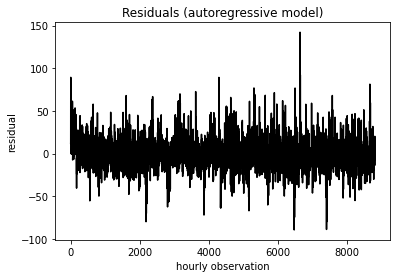

In [36]:
plt.plot(xsort, res, color='k')
plt.ylabel("residual")
plt.xlabel("hourly observation")
plt.title("Residuals (autoregressive model)")
plt.show()

### 7.2

(using Goodreads data from examples above)

In [37]:
len(interactions)

542338

In [38]:
interactionsTrain = interactionsWithPrevious[:500000]
interactionsTest = interactionsWithPrevious[500000:]

The FPMC implementation we built above allowed us to control which terms (user/item or item/item) were included

In [39]:
modelFPMC = FPMC(5, 0.001, 1, 1)
modelMF = FPMC(5, 0.001, 1, 0)
modelFMC = FPMC(5, 0.001, 0, 1)

In [40]:
interactionsTestPerUser = defaultdict(set)
itemSet = set()
for _,u,i,j,_ in interactionsTest:
    interactionsTestPerUser[u].add((i,j))
    itemSet.add(i)
    itemSet.add(j)

In [41]:
def AUCu(model, u, N):
    win = 0
    if N > len(interactionsTestPerUser[u]):
        N = len(interactionsTestPerUser[u])
    positive = random.sample(interactionsTestPerUser[u],N)
    negative = random.sample(itemSet,N)
    for (i,j),k in zip(positive,negative):
        sp = model.predict(userIDs[u], itemIDs[i], itemIDs[j]).numpy()
        sn = model.predict(userIDs[u], itemIDs[k], itemIDs[j]).numpy()
        if sp > sn:
            win += 1
    return win/N

In [42]:
def AUC(model):
    av = []
    for u in interactionsTestPerUser:
        av.append(AUCu(model, u, 10))
    return sum(av) / len(av)

In [43]:
for model,name in [(modelFPMC,"FPMC"), (modelMF,"MF"), (modelFMC,"FMC")]:
    for i in range(100):
        obj = trainingStep(model, interactionsTrain)
        if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))
    print(name + " AUC = " + str(AUC(model)))

iteration 10, objective = 1.1746131
iteration 20, objective = 0.92867684
iteration 30, objective = 0.7483735
iteration 40, objective = 0.70032424
iteration 50, objective = 0.6855321
iteration 60, objective = 0.6804432
iteration 70, objective = 0.6787539
iteration 80, objective = 0.67819005
iteration 90, objective = 0.6775411
iteration 100, objective = 0.67795616
FPMC AUC = 0.747250442308484
iteration 10, objective = 1.2138934
iteration 20, objective = 0.92614543
iteration 30, objective = 0.87164855
iteration 40, objective = 0.7574963
iteration 50, objective = 0.6932193
iteration 60, objective = 0.6804425
iteration 70, objective = 0.67617583
iteration 80, objective = 0.67497826
iteration 90, objective = 0.67435545
iteration 100, objective = 0.67418957
MF AUC = 0.7297063143225662
iteration 10, objective = 1.2454288
iteration 20, objective = 1.1203403
iteration 30, objective = 1.0467294
iteration 40, objective = 0.7611709
iteration 50, objective = 0.7087674
iteration 60, objective = 0.691

### 7.3

FISM implementaion, using a factorization machine

In [44]:
nItems = len(itemIDs)
nUsers = len(userIDs)

In [45]:
fismInter = random.sample(interactions,100000)

Factorization machine design matrix. Note that we have two sets of features (the user history, and the target item). Both are of dimension nItems.

In [46]:
X = scipy.sparse.lil_matrix((len(fismInter), 2*nItems))

In [47]:
for n in range(len(fismInter)):
    _,u,i,r = fismInter[n]
    item = itemIDs[i]
    history = itemsPerUser[u]
    for j in history:
        if i == j: continue # Exclude the target item from the history
        X[n,itemIDs[j]] = 1.0 / (len(history) - 1) # One-hot encoding, normalized by history length
    X[n,nItems + item] = 1.0

X = X.tocsr()

In [48]:
y = [float(r) for _,_,_,r in fismInter]

Fairly slow and memory-hungry (every row contains a copy of a user's history). Could possibly be implemented faster in Tensorflow.

In [49]:
fm = pylibfm.FM(num_factors=5, num_iter=50, verbose=True, task="regression", initial_learning_rate=0.001, learning_rate_schedule="optimal")

In [50]:
X_train,y_train = X[:90000],y[:90000]
X_test,y_test = X[90000:],y[90000:]

In [ ]:
fm.fit(X_train, y_train)

In [52]:
y_pred = fm.predict(X_test)

In [53]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [54]:
MSE(y_pred, y_test)

1.2513683700551304

### 7.4

(still using Goodreads data)

In [55]:
interactions.sort()

In [56]:
interactionsPerItem = defaultdict(list)
for t,u,i,r in interactions:
    interactionsPerItem[i].append((t,u,r))

In [57]:
random.shuffle(interactions)

Regression-based approach. Just collect past K interactions (ratings) as features.

In [58]:
def feat(t,u,i):
    older = [r for (q,u,r) in interactionsPerItem[i] if q < t] # Collect previous ratings
    f = []
    for k in range(1,6):
        try:
            f += [0,older[-k]] # Previous rating
        except Exception as e:
            f += [1,0] # Or missing value indicator if we don't have history of length k
    if len(older):
        f += [0,sum(older)/len(older)] # Add feature for the average (going beyond just last k)
    else:
        f += [1,0] # Missing value indicator if no interaction history
    return f + [1]

In [59]:
X = [feat(t,u,i) for t,u,i,_ in interactions]
y = [float(r) for _,_,_,r in interactions]

In [60]:
X_train, X_test = X[:400000],X[400000:]
y_train, Y_test = y[:400000],y[400000:]

In [61]:
model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)
theta = model.coef_
theta

array([0.58075996, 0.02085035, 0.1677423 , 0.04391613, 0.17853936,
       0.04630484, 0.16557961, 0.0504245 , 0.13288449, 0.05048648,
       0.58075996, 0.29277262, 1.8875998 ])

In [62]:
y_pred = model.predict(X_test)

In [63]:
MSE(y_pred, y_test)

1.4062538065080719

Factorization machine-based approach. Copy the same features from the model above, but also include a user term. In theory, this should allow us to learn how sensitive a particular user is to herding.

In [64]:
XF = scipy.sparse.lil_matrix((len(interactions), nUsers + len(X[0])))

In [66]:
for n in range(len(interactions)):
    _,u,i,r = interactions[n]
    user = userIDs[u]
    XF[n,user] = 1
    for j in range(len(X[n])): # Copy features from previous model
        XF[n,nUsers+j] = X[n][j]
XF = XF.tocsr()

In [67]:
fm = pylibfm.FM(num_factors=5, num_iter=50, verbose=False, task="regression", initial_learning_rate=0.001, learning_rate_schedule="optimal")

In [68]:
X_train,y_train = XF[:400000],y[:400000]
X_test,y_test = XF[400000:],y[400000:]

In [69]:
fm.fit(X_train, y_train)

In [ ]:
y_pred = fm.predict(X_test)

In [ ]:
MSE(y_pred, y_test)

1.5863953730808005